In [2]:
from Bio.Blast import NCBIWWW

from Bio.Blast.Applications import NcbiblastpCommandline
from io import StringIO 
from Bio.Blast import NCBIXML
from Bio.Blast import NCBIWWW

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

import numpy
import time

In [42]:
s = SeqIO.parse('kinase_domains.txt', 'fasta') # single sequence fasta file
for i,thing in enumerate(s):
    print(thing,"\n")

ID: Hs_AKT1.kin_dom
Name: Hs_AKT1.kin_dom
Description: Hs_AKT1.kin_dom class=AGC:Akt: gene=AKT1 species="Human"
Number of features: 0
Seq('FEYLKLLGKGTFGKVILVKEKATGRYYAMKILKKEVIVAKDEVAHTLTENRVLQ...RFF', SingleLetterAlphabet()) 

ID: Hs_AKT2.kin_dom
Name: Hs_AKT2.kin_dom
Description: Hs_AKT2.kin_dom class=AGC:Akt: gene=AKT2 species="Human"
Number of features: 0
Seq('FDYLKLLGKGTFGKVILVREKATGRYYAMKILRKEVIIAKDEVAHTVTESRVLQ...RFF', SingleLetterAlphabet()) 

ID: Hs_AKT3.kin_dom
Name: Hs_AKT3.kin_dom
Description: Hs_AKT3.kin_dom class=AGC:Akt: gene=AKT3 species="Human"
Number of features: 0
Seq('FDYLKLLGKGTFGKVILVREKASGKYYAMKILKKEVIIAKDEVAHTLTESRVLK...SFF', SingleLetterAlphabet()) 

ID: Hs_CRIK.kin_dom
Name: Hs_CRIK.kin_dom
Description: Hs_CRIK.kin_dom class=AGC:DMPK:CRIK gene=CRIK species="Human"
Number of features: 0
Seq('FEVRSLVGCGHFAEVQVVREKATGDIYAMKVMKKKALLAQEQVSFFEEERNILS...PFF', SingleLetterAlphabet()) 

ID: Hs_DMPK1.kin_dom
Name: Hs_DMPK1.kin_dom
Description: Hs_DMPK1.kin_dom class=AGC

In [44]:
n = 0
with open('kinase_domains.txt', 'r') as f:
    for line in f:
        n += 1
        print(line.strip(),"\n")

>Hs_AKT1.kin_dom class=AGC:Akt: gene=AKT1 species="Human" 

FEYLKLLGKGTFGKVILVKEKATGRYYAMKILKKEVIVAKDEVAHTLTENRVLQNSRHPF 

LTALKYSFQTHDRLCFVMEYANGGELFFHLSRERVFSEDRARFYGAEIVSALDYLHSEKN 

VVYRDLKLENLMLDKDGHIKITDFGLCKEGIKDGATMKTFCGTPEYLAPEVLEDNDYGRA 

VDWWGLGVVMYEMMCGRLPFYNQDHEKLFELILMEEIRFPRTLGPEAKSLLSGLLKKDPK 

QRLGGGSEDAKEIMQHRFF 

 

>Hs_AKT2.kin_dom class=AGC:Akt: gene=AKT2 species="Human" 

FDYLKLLGKGTFGKVILVREKATGRYYAMKILRKEVIIAKDEVAHTVTESRVLQNTRHPF 

LTALKYAFQTHDRLCFVMEYANGGELFFHLSRERVFTEERARFYGAEIVSALEYLHSRDV 

VYRDIKLENLMLDKDGHIKITDFGLCKEGISDGATMKTFCGTPEYLAPEVLEDNDYGRAV 

DWWGLGVVMYEMMCGRLPFYNQDHERLFELILMEEIRFPRTLSPEAKSLLAGLLKKDPKQ 

RLGGGPSDAKEVMEHRFF 

 

>Hs_AKT3.kin_dom class=AGC:Akt: gene=AKT3 species="Human" 

FDYLKLLGKGTFGKVILVREKASGKYYAMKILKKEVIIAKDEVAHTLTESRVLKNTRHPF 

LTSLKYSFQTKDRLCFVMEYVNGGELFFHLSRERVFSEDRTRFYGAEIVSALDYLHSGKI 

VYRDLKLENLMLDKDGHIKITDFGLCKEGITDAATMKTFCGTPEYLAPEVLEDNDYGRAV 

DWWGLGVVMYEMMCGRLPFYNQDHEKLFELILMEDIKFPRTLSSDAKSLLSGLLIKDPNK 

RLGGGPDDAKEIMRH

In [75]:
lines = []
with open('kinase_domains.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            lines.append(line)

fam_to_seqs = {}
seqs = []
fams = []

isKinase = False
kinase = False
for line in lines:
    
    if line[0]=='>':
        if kinase:
            seqs.append(seq)
            fams.append(kinase)
            if kinase in fam_to_seqs.keys():
                fam_to_seqs[kinase].append(seq)
            else:
                fam_to_seqs[kinase] = [seq]
        isKinase = True
        kinase = line[line.find(':')+1:]
        kinase = kinase[:kinase.find(':')]
        seq = ''
    else:
        isKinase = False
        seq = seq + line

In [90]:
seqs = numpy.array((list(set((seqs)))))
fams = numpy.array((list(set(fams))))

In [91]:
len(seqs)

530

In [92]:
start = time.time()
alignments = numpy.full((len(seqs),len(seqs)),-1.0)

for i,seq_train in enumerate(seqs):
    seq_train = ''.join([x for x in seq_train])
    seq_train = seq_train.replace('-',' ')
    
    if i%2==0:
        print ('iter %d | %5.3f secs' % (i, time.time()-start) )
        start = time.time()
    seq_train = SeqRecord(Seq(seq_train), id="seq_train")
    SeqIO.write(seq_train, "seq_train.fasta", "fasta")
    
    for j,seq_test in enumerate(seqs):
        
        if alignments[i][j] != -1 or i==j:
            continue
            
        seq_test = ''.join([x for x in seq_test])
        seq_test = seq_test.replace('-',' ')

        blastp_cline = NcbiblastpCommandline(subject = 'seq_train.fasta', outfmt=5) #Blast command
        out, err = blastp_cline(seq_test)
        blast_result_record = NCBIXML.read(StringIO(out))
        
        maxIdentity = 0.0
        
        if not blast_result_record.alignments:
            continue
        for alignment in blast_result_record.alignments:
            for hsp in alignment.hsps:
                if (hsp.identities/ hsp.align_length) >= maxIdentity:
                    maxIdentity = (hsp.identities/ hsp.align_length)
        
#         print(type(maxIdentity))
        alignments[i][j] = maxIdentity
#         break
        
        
print ('Total time: %5.3f secs' % (time.time()-start) )

iter 0 | 0.003 secs
iter 2 | 32.024 secs
iter 4 | 30.811 secs
iter 6 | 30.180 secs
iter 8 | 36.846 secs
iter 10 | 30.262 secs
iter 12 | 30.270 secs
iter 14 | 30.102 secs
iter 16 | 30.521 secs
iter 18 | 31.881 secs
iter 20 | 31.890 secs
iter 22 | 31.219 secs
iter 24 | 31.003 secs
iter 26 | 30.249 secs
iter 28 | 39.864 secs
iter 30 | 33.209 secs
iter 32 | 34.515 secs
iter 34 | 34.373 secs
iter 36 | 34.401 secs
iter 38 | 32.693 secs
iter 40 | 33.190 secs
iter 42 | 33.374 secs
iter 44 | 33.014 secs
iter 46 | 32.561 secs
iter 48 | 31.777 secs
iter 50 | 35.064 secs
iter 52 | 34.269 secs
iter 54 | 32.779 secs
iter 56 | 32.791 secs
iter 58 | 32.370 secs
iter 60 | 32.894 secs
iter 62 | 32.206 secs
iter 64 | 32.878 secs
iter 66 | 33.951 secs
iter 68 | 36.054 secs
iter 70 | 31.676 secs
iter 72 | 33.033 secs
iter 74 | 35.224 secs
iter 76 | 32.708 secs
iter 78 | 33.613 secs
iter 80 | 36.023 secs
iter 82 | 36.043 secs
iter 84 | 32.511 secs
iter 86 | 31.972 secs
iter 88 | 32.188 secs
iter 90 | 32.179

In [96]:
import pandas
df = pandas.DataFrame(alignments,dtype=float)
df.to_csv('alignments_19.10.15.csv',header=None,index=None)

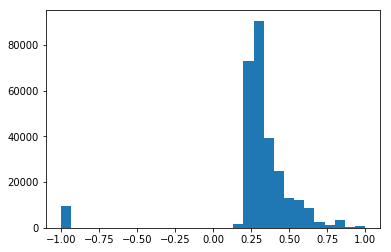

In [99]:
import numpy as np
import matplotlib.pyplot as plt

toPlot = alignments.flatten()
plt.hist(toPlot,bins=30)
plt.show()

In [113]:
from itertools import combinations 
from itertools import product 

famPair_to_kinaseDistances = {tuple((pair[0],pair[1])):[] for pair in combinations(fams,2)}

for pair in combinations(fams,2):
    
    fam1 = pair[0]
    fam2 = pair[1]
    
    seqList1 = fam_to_seqs[fam1]
    seqList2 = fam_to_seqs[fam2]
        
    for pair2 in product(seqList1,seqList2):
        
        seq1 = pair2[0]
        seq2 = pair2[1]
        
        seqIdx1 = numpy.where(seqs==seq1)[0][0]
        seqIdx2 = numpy.where(seqs==seq2)[0][0]
        
        distance = alignments[seqIdx1][seqIdx2]
        if distance < 0 and distance > -1:
            print(distance)
        
        if distance == -1.0:
            continue

        famPair_to_kinaseDistances[tuple((fam1,fam2))].append(distance)
        
#         print(fam1,kinase1,fam2,kinase2,distance)

In [170]:
famDistanceMatrix = numpy.full((len(fams),len(fams)),-1.0)

for k,v in famPair_to_kinaseDistances.items():
    toAvg = list(set(v))
    if 'PKA' in k and 'CK2' in k:
        print(k,toAvg,fam_to_seqs[k[0]],fam_to_seqs[k[1]])
    toAvg = numpy.array((v))
    toAvg = toAvg[toAvg < 1.0]

#     if 1 in v and 'PKA' in k:
#         print(k,v)
    avgDistance = numpy.median(toAvg)
    
    if 'PKA' in k and 'CK2' in k:
        print(k,avgDistance)

    fIdx1 = numpy.where(fams==k[0])[0][0]
    fIdx2 = numpy.where(fams==k[1])[0][0]
    famDistanceMatrix[fIdx1][fIdx2] = avgDistance
    
for i,row in enumerate(famDistanceMatrix):
    for j,val in enumerate(row):
        famDistanceMatrix[j][i] = famDistanceMatrix[i][j]
        
for i,row in enumerate(famDistanceMatrix):
    for j,val in enumerate(row):
        if i==j:
            famDistanceMatrix[i][j] = 1
        elif val == -1:
            famDistanceMatrix[i][j] = 0

('CK2', 'PKA') [0.3076923076923077, 0.5714285714285714, 0.6, 0.31, 0.29457364341085274] ['YQLVRKLGRGKYSEVFEAINITNNEKVVVKILKPVKKKKIKREIKILENLRGGPNIITLADIVKDPVSRTPALVFEHVNNTDFKQLYQTLTDYDIRFYMYEILKALDYCHSMGIMHRDVKPHNVMIDHEHRKLRLIDWGLAEFYHPGQEYNVRVASRYFKGPELLVDYQMYDYSLDMWSLGCMLASMIFRKEPFFHGHDNYDQLVRIAKVLGTEDLYDYIDKYNIELDPRFNDILGRHSRKRWERFVHSENQHLVSPEALDFLDKLLRYDHQSRLTAREAMEHPYF', 'YQLVRKLGRGKYSEVFEAINITNNERVVVKILKPVKKKKIKREVKILENLRGGTNIIKLIDTVKDPVSKTPALVFEYINNTDFKQLYQILTDFDIRFYMYELLKALDYCHSKGIMHRDVKPHNVMIDHQQKKLRLIDWGLAEFYHPAQEYNVRVASRYFKGPELLVDYQMYDYSLDMWSLGCMLASMIFRREPFFHGQDNYDQLVRIAKVLGTEELYGYLKKYHIDLDPHFNDILGQHSRKRWENFIHSENRHLVSPEALDLLDKLLRYDHQQRLTAKEAMEHPYF'] ['FERIKTLGTGSFGRVMLVKHKETGNHYAMKILDKQKVVKLKQIEHTLNEKRILQAVNFPFLVKLEFSFKDNSNLYMVMEYVPGGEMFSHLRRIGRFSEPHARFYAAQIVLTFEYLHSLDLIYRDLKPENLLIDQQGYIQVTDFGFAKRVKGRTWTLCGTPEYLAPEIILSKGYNKAVDWWALGVLIYEMAAGYPPFFADQPIQIYEKIVSGKVRFPSHFSSDLKDLLRNLLQVDLTKRFGNLKNGVNDIKNHKWF', 'FERKKTLGTGSFGRVMLVKHKATEQYYAMKILDKQKVVKLKQIEHTLNEKRILQAVNFPFLVRLEYAFKD

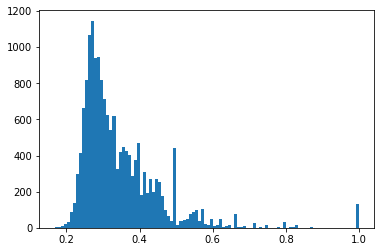

In [167]:
toPlot = famDistanceMatrix[famDistanceMatrix!=0]

plt.hist(toPlot,bins=100)
plt.show()

In [168]:
someKs = ['MAPK', 'Src','PKC','PKA','CDK','CK2']

for pair in combinations(someKs,2):
    i = numpy.where(fams==pair[0])[0][0]
    j = numpy.where(fams==pair[1])[0][0]
    p = famDistanceMatrix[i][j]
    if p==-1:
        p = famDistanceMatrix[j][i]
    print(pair[0],pair[1],p)

MAPK Src 0.2899576704130784
MAPK PKC 0.30852135374697826
MAPK PKA 0.30668473351400183
MAPK CDK 0.3473699763593381
MAPK CK2 0.30478424850770647
Src PKC 0.26666666666666666
Src PKA 0.2684563758389262
Src CDK 0.28870549481356883
Src CK2 0.238510101010101
PKC PKA 0.4
PKC CDK 0.28125
PKC CK2 0.32236227824463115
PKA CDK 0.2914572864321608
PKA CK2 0.4407142857142857
CDK CK2 0.294635916040425


In [176]:
import numpy
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
import Levenshtein
from Levenshtein import hamming
from itertools import combinations
import matplotlib.pyplot as plt
import math
import random
from Bio import pairwise2
from Bio import Align
from Bio.SubsMat import MatrixInfo
import sklearn.cluster
import itertools
import time

In [259]:
alignments2 = numpy.full((len(seqs),len(seqs)),-1.0)

aligner = Align.PairwiseAligner()
aligner.substitution_matrix = MatrixInfo.blosum62 #MatrixInfo.  pam30
aligner.mode = 'local'

for i,seq1 in enumerate(seqs):  
    if i%2==0:
        print ('iter %d | %5.3f secs' % (i, time.time()-start) )
        start = time.time()
    for j,seq2 in enumerate(seqs):
        
        
        if alignments2[j][i] != -1: # or i==j:
            continue
        if len(seq1)==3 or len(seq2)==3:
#             print("fsdfdfs:",seq1,seq2)
            continue
        score = aligner.align(seq1,seq2).score
#         print(score)
        alignments2[i][j] = score
        alignments2[j][i] = score

iter 0 | 61565.706 secs
iter 2 | 1.089 secs
iter 4 | 1.003 secs
iter 6 | 1.054 secs
iter 8 | 0.781 secs
iter 10 | 1.037 secs
iter 12 | 1.010 secs
iter 14 | 1.117 secs
iter 16 | 0.950 secs
iter 18 | 0.944 secs
iter 20 | 1.037 secs
iter 22 | 0.986 secs
iter 24 | 0.934 secs
iter 26 | 1.090 secs
iter 28 | 0.932 secs
iter 30 | 0.913 secs
iter 32 | 1.010 secs
iter 34 | 0.891 secs
iter 36 | 1.390 secs
iter 38 | 0.989 secs
iter 40 | 0.937 secs
iter 42 | 0.896 secs
iter 44 | 1.019 secs
iter 46 | 1.421 secs
iter 48 | 0.881 secs
iter 50 | 0.912 secs
iter 52 | 1.041 secs
iter 54 | 0.881 secs
iter 56 | 0.924 secs
iter 58 | 0.689 secs
iter 60 | 0.938 secs
iter 62 | 1.061 secs
iter 64 | 1.017 secs
iter 66 | 1.087 secs
iter 68 | 0.960 secs
iter 70 | 0.988 secs
iter 72 | 0.859 secs
iter 74 | 0.853 secs
iter 76 | 0.841 secs
iter 78 | 0.939 secs
iter 80 | 0.941 secs
iter 82 | 0.985 secs
iter 84 | 0.831 secs
iter 86 | 0.838 secs
iter 88 | 0.857 secs
iter 90 | 0.854 secs
iter 92 | 0.833 secs
iter 94 | 0.86

In [260]:
alignments2

array([[1370.,  686.,  650., ...,  384.,  628.,  633.],
       [ 686., 1499.,  663., ...,  435.,  668.,  673.],
       [ 650.,  663., 1391., ...,  396.,  631.,  620.],
       ...,
       [ 384.,  435.,  396., ...,  721.,  387.,  425.],
       [ 628.,  668.,  631., ...,  387., 1395.,  650.],
       [ 633.,  673.,  620., ...,  425.,  650., 1845.]])

[1370.  686.  650. ...  425.  650. 1845.]


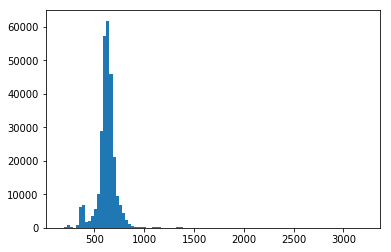

In [261]:
import numpy as np
import matplotlib.pyplot as plt

toPlot = alignments2.flatten()
toPlot = toPlot[toPlot != -1]

print(toPlot)

plt.hist(toPlot,bins=100)
plt.show()

In [263]:
from itertools import combinations 
from itertools import product 

famPair_to_kinaseDistances2 = {tuple((pair[0],pair[1])):[] for pair in combinations(fams,2)}

for pair in combinations(fams,2):
    fam1 = pair[0]
    fam2 = pair[1]
    seqList1 = fam_to_seqs[fam1]
    seqList2 = fam_to_seqs[fam2]
        
    for pair2 in product(seqList1,seqList2): 
        seq1 = pair2[0]
        seq2 = pair2[1]
        seqIdx1 = numpy.where(seqs==seq1)[0][0]
        seqIdx2 = numpy.where(seqs==seq2)[0][0]
        
        distance = alignments2[seqIdx1][seqIdx2]
        if distance < 0 and distance > -1:
            print(distance)
        if distance == -1.0:
            continue

        famPair_to_kinaseDistances2[tuple((fam1,fam2))].append(distance)
        

dupFamTups = [tuple((f,f)) for f in fams]
for ff in dupFamTups:
    famPair_to_kinaseDistances2[ff] = []

for pair in dupFamTups:
    fam1 = pair[0]
    fam2 = pair[1]
    seqList1 = fam_to_seqs[fam1]
    seqList2 = fam_to_seqs[fam2]
        
    for pair2 in product(seqList1,seqList2):
        seq1 = pair2[0]
        seq2 = pair2[1]
        seqIdx1 = numpy.where(seqs==seq1)[0][0]
        seqIdx2 = numpy.where(seqs==seq2)[0][0]
        
        distance = alignments2[seqIdx1][seqIdx2]
        if distance < 0 and distance > -1:
            print(distance)
        if distance == -1.0:
            continue

        famPair_to_kinaseDistances2[tuple((fam1,fam2))].append(distance)      
        
        
        
        
        
        

famDistanceMatrix2 = numpy.full((len(fams),len(fams)),-1.0)

for k,v in famPair_to_kinaseDistances2.items():
    toAvg = list(set(v))
#     if 'PKA' in k and 'CK2' in k:
#         print(k,toAvg,fam_to_seqs[k[0]],fam_to_seqs[k[1]])
    toAvg = numpy.array((v))
    avgDistance = numpy.mean(toAvg)
    fIdx1 = numpy.where(fams==k[0])[0][0]
    fIdx2 = numpy.where(fams==k[1])[0][0]
    famDistanceMatrix2[fIdx1][fIdx2] = avgDistance
    
for i,row in enumerate(famDistanceMatrix):
    for j,val in enumerate(row):
        famDistanceMatrix2[j][i] = famDistanceMatrix2[i][j]
        
for i,row in enumerate(famDistanceMatrix2):
    for j,val in enumerate(row):
#         if i==j:
#             famDistanceMatrix2[i][j] = 1
        if val == -1:
            famDistanceMatrix2[i][j] = 0

In [265]:
someKs = ['MAPK', 'Src','PKC','PKA','CDK','CK2']
dups = [[f,f] for f in someKs]

for pair in combinations(someKs,2):
    i = numpy.where(fams==pair[0])[0][0]
    j = numpy.where(fams==pair[1])[0][0]
    p = famDistanceMatrix2[i][j]
    print(pair[0],pair[1],p)
for pair in dups:
    i = numpy.where(fams==pair[0])[0][0]
    j = numpy.where(fams==pair[1])[0][0]
    p = famDistanceMatrix2[i][j]
    print(pair[0],pair[1],p)

MAPK Src 642.1298701298701
MAPK PKC 646.2698412698413
MAPK PKA 632.4428571428572
MAPK CDK 779.5034013605442
MAPK CK2 736.8571428571429
Src PKC 593.8585858585859
Src PKA 559.7636363636364
Src CDK 642.6277056277056
Src CK2 592.5454545454545
PKC PKA 743.8666666666667
PKC CDK 655.8994708994709
PKC CK2 643.5555555555555
PKA CDK 635.1238095238095
PKA CK2 607.9
CDK CK2 726.6190476190476
MAPK MAPK 961.015306122449
Src Src 986.1900826446281
PKC PKC 1036.320987654321
PKA PKA 1055.2
CDK CDK 923.8208616780046
CK2 CK2 1456.5


In [266]:
maximum = numpy.max(famDistanceMatrix2)
minimum = numpy.min(famDistanceMatrix2)

famDistanceMatrix2_scaled = numpy.array((famDistanceMatrix2))
for i in range(len(fams)):
    for j in range(len(fams)):
        famDistanceMatrix2_scaled[i][j] = 1 - float(famDistanceMatrix2[i][j]-minimum)/(maximum-minimum) 

In [267]:
someKs = ['MAPK', 'Src','PKC','PKA','CDK','CK2','Akt']

for pair in combinations(someKs,2):
    i = numpy.where(fams==pair[0])[0][0]
    j = numpy.where(fams==pair[1])[0][0]
    p = famDistanceMatrix_pam[i][j]
    print(pair[0],pair[1],p)

MAPK Src 0.4334640322858291
MAPK PKC 0.42980573672768074
MAPK PKA 0.4420239848516726
MAPK CDK 0.3120735775900936
MAPK CK2 0.3497580475489165
MAPK Akt 0.4308015989901116
Src PKC 0.47611906993350295
Src PKA 0.5062471549069487
Src CDK 0.4330241187384045
Src CK2 0.4772794216093186
Src Akt 0.48009104297764094
PKC PKA 0.3435640648011783
PKC CDK 0.4212964911050331
PKC CK2 0.43220422189494356
PKC Akt 0.23207331042382595
PKA CDK 0.4396549547654114
PKA CK2 0.46371134020618565
PKA Akt 0.3034462444771724
CDK CK2 0.3588049652850832
CDK Akt 0.422806648432569
CK2 Akt 0.42636229749631815


In [268]:
famDistanceMatrix_pam = numpy.array((famDistanceMatrix2_scaled))

import pandas
df = pandas.DataFrame(famDistanceMatrix_pam,dtype=float)
df.to_csv('Final_data/famDistanceMatrix_pam_19.10.16.csv',header=None,index=None)

In [269]:
df = pandas.DataFrame(fams,dtype='U')
df.to_csv('Final_data/fams_forPamDistMatrix_19.10.16.csv',header=None,index=None)

In [257]:
len(fams)

129

In [273]:
famDistanceMatrix_pam[1][1]

0.5107686400446803